In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
from IPython.display import FileLink

In [2]:
class SeedlingDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0]
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        labels = self.labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        return image, int(labels)

In [3]:
data_dir = '/home/tyler/storage/plant_seedlings/'
storage_dir = data_dir + 'results/'
result_file = storage_dir + 'plant_seedling_results.csv'
image_size = 224
batch_size = 8
classes = listdir(data_dir + 'train/')
classes = sorted(classes, key=lambda item: (int(item.partition(' ')[0])
                               if item[0].isdigit() else float('inf'), item))
num_to_class = dict(zip(range(len(classes)), classes))
num_to_class

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: 'Shepherds Purse',
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}

In [4]:
train = []
for index, label in enumerate(classes):
    path = data_dir + 'train/' + label + '/'
    for file in listdir(path):
        train.append(['{}/{}'.format(label, file), label, index])
    
df = pd.DataFrame(train, columns=['file', 'category', 'category_id',]) 
df

,file,category,category_id
0,Black-grass/c66bab8b6.png,Black-grass,0
1,Black-grass/4f0dcbcc3.png,Black-grass,0
2,Black-grass/7b71d3e65.png,Black-grass,0
3,Black-grass/d8afd58f3.png,Black-grass,0
4,Black-grass/fc1001932.png,Black-grass,0
5,Black-grass/8029e3396.png,Black-grass,0
6,Black-grass/3b7d1fe82.png,Black-grass,0
7,Black-grass/adc5443dc.png,Black-grass,0
8,Black-grass/d090d6b25.png,Black-grass,0
9,Black-grass/92e5fcce4.png,Black-grass,0


In [5]:
train_data = df.sample(frac=0.7)
valid_data = df[~df['file'].isin(train_data['file'])]
sample_submission = pd.read_csv(data_dir + 'sample_submission.csv')
sample_submission.columns = ['file', 'category']
sample_submission['category_id'] = 0
sample_submission

,file,category,category_id
0,0021e90e4.png,Sugar beet,0
1,003d61042.png,Sugar beet,0
2,007b3da8b.png,Sugar beet,0
3,0086a6340.png,Sugar beet,0
4,00c47e980.png,Sugar beet,0
5,00d090cde.png,Sugar beet,0
6,00ef713a8.png,Sugar beet,0
7,01291174f.png,Sugar beet,0
8,026716f9b.png,Sugar beet,0
9,02cfeb38d.png,Sugar beet,0


In [6]:
train_trans = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_trans = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set = SeedlingDataset(train_data, data_dir + 'train/', transform = train_trans)
valid_set = SeedlingDataset(valid_data, data_dir + 'train/', transform = valid_trans)
test_set = SeedlingDataset(sample_submission, data_dir + 'test/', transform = valid_trans)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

dataset_sizes = {
    'train': len(train_loader.dataset), 
    'valid': len(valid_loader.dataset)
}

In [7]:
def imshow(axis, inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

IndexError: list index out of range

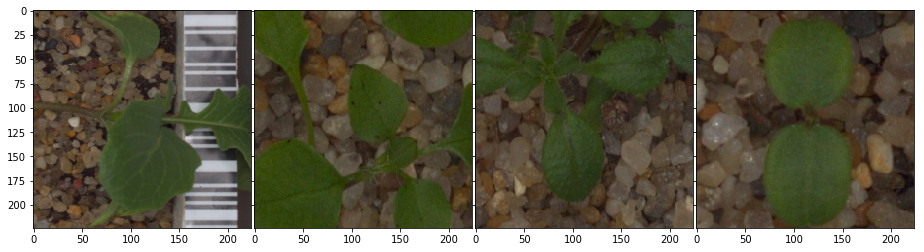

In [9]:
img, label = next(iter(train_loader))
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

In [11]:
def train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_batch = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                labels = labels.view(-1)
                
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                running_batch +=1

            epoch_loss = running_loss / running_batch
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
use_gpu = torch.cuda.is_available()

resnet = models.resnet50(pretrained=True)
# freeze all model parameters
for param in resnet.parameters():
    param.requires_grad = False

num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, len(classes))
if use_gpu:
    resnet = resnet.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

loaders = {'train':train_loader, 'valid':valid_loader, 'test': test_loader}

In [13]:
start_time = time.time()
model = train_model(loaders, resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=20)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch 0/19
----------
train Loss: 1.9616 Acc: 0.3546
valid Loss: 1.2994 Acc: 0.5677
Epoch 1/19
----------
train Loss: 1.5265 Acc: 0.5035
valid Loss: 1.0136 Acc: 0.6744
Epoch 2/19
----------
train Loss: 1.3773 Acc: 0.5588
valid Loss: 0.9263 Acc: 0.7074
Epoch 3/19
----------
train Loss: 1.2723 Acc: 0.5798
valid Loss: 0.8039 Acc: 0.7291
Epoch 4/19
----------
train Loss: 1.2113 Acc: 0.6057
valid Loss: 0.7479 Acc: 0.7818
Epoch 5/19
----------
train Loss: 1.1636 Acc: 0.6325
valid Loss: 0.8216 Acc: 0.7172
Epoch 6/19
----------
train Loss: 1.1304 Acc: 0.6195
valid Loss: 0.7110 Acc: 0.7530
Epoch 7/19
----------
train Loss: 1.0474 Acc: 0.6650
valid Loss: 0.6711 Acc: 0.7944
Epoch 8/19
----------
train Loss: 1.0229 Acc: 0.6782
valid Loss: 0.6642 Acc: 0.7860
Epoch 9/19
----------
train Loss: 1.0597 Acc: 0.6538
valid Loss: 0.6621 Acc: 0.7839
Epoch 10/19
----------
train Loss: 1.0501 Acc: 0.6623
valid Loss: 0.6426 Acc: 0.7979
Epoch 11/19
----------
train Loss: 1.0321 Acc: 0.6731
valid Loss: 0.6559 Ac

In [14]:
path = storage_dir
torch.save(resnet.state_dict(), path + 'weights.torch')

In [15]:
resnet.load_state_dict(torch.load(path + 'weights.torch'))
resnet.eval()

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d (64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1):

In [17]:
predictions = []
for i, (input, labels) in enumerate(test_loader):
    val = input.cuda()
    
    input = torch.autograd.Variable(val, volatile=True)
    output = resnet(input)
    prediction_matrix = func.softmax(output, dim=1).cpu().data.numpy()
    for index, pred in enumerate(prediction_matrix):
        predictions.append(pred.argmax())
    print('\r ' + str(i), end='') 
predictions


 99

[10,
 5,
 11,
 3,
 11,
 6,
 3,
 5,
 6,
 6,
 3,
 10,
 11,
 8,
 11,
 5,
 8,
 8,
 3,
 10,
 3,
 10,
 9,
 11,
 11,
 1,
 8,
 8,
 3,
 11,
 3,
 9,
 6,
 7,
 6,
 4,
 6,
 6,
 3,
 7,
 6,
 4,
 3,
 10,
 11,
 11,
 7,
 8,
 7,
 10,
 6,
 11,
 2,
 6,
 1,
 5,
 1,
 10,
 2,
 6,
 11,
 2,
 1,
 4,
 7,
 5,
 6,
 6,
 3,
 8,
 10,
 5,
 8,
 3,
 5,
 4,
 6,
 8,
 8,
 6,
 8,
 3,
 3,
 4,
 10,
 5,
 2,
 1,
 11,
 6,
 1,
 6,
 5,
 6,
 3,
 6,
 10,
 8,
 7,
 10,
 11,
 5,
 8,
 11,
 5,
 5,
 3,
 8,
 2,
 2,
 6,
 1,
 5,
 3,
 3,
 11,
 2,
 1,
 11,
 3,
 11,
 11,
 2,
 6,
 7,
 4,
 1,
 7,
 5,
 3,
 11,
 11,
 3,
 5,
 5,
 4,
 5,
 1,
 6,
 3,
 6,
 10,
 1,
 3,
 5,
 11,
 4,
 10,
 11,
 1,
 8,
 6,
 7,
 8,
 6,
 10,
 5,
 5,
 6,
 2,
 1,
 6,
 8,
 3,
 10,
 0,
 8,
 4,
 11,
 3,
 9,
 7,
 1,
 5,
 5,
 10,
 6,
 2,
 6,
 6,
 6,
 10,
 6,
 6,
 3,
 6,
 3,
 5,
 5,
 10,
 6,
 1,
 6,
 4,
 1,
 6,
 4,
 3,
 6,
 3,
 2,
 6,
 1,
 1,
 10,
 2,
 5,
 3,
 5,
 3,
 11,
 1,
 5,
 6,
 10,
 2,
 1,
 6,
 10,
 3,
 8,
 6,
 3,
 10,
 4,
 5,
 5,
 3,
 3,
 7,
 10,
 2,
 9,
 2,
 3,
 6,
 6,
 2,
 

In [18]:
submission = sample_submission.copy()
for index, prediction in enumerate(predictions):
    submission.set_value(index, 'category_id', prediction)
    submission.set_value(index, 'category', num_to_class[prediction])
submission

,file,category,category_id
0,0021e90e4.png,Small-flowered Cranesbill,10
1,003d61042.png,Fat Hen,5
2,007b3da8b.png,Sugar beet,11
3,0086a6340.png,Common Chickweed,3
4,00c47e980.png,Sugar beet,11
5,00d090cde.png,Loose Silky-bent,6
6,00ef713a8.png,Common Chickweed,3
7,01291174f.png,Fat Hen,5
8,026716f9b.png,Loose Silky-bent,6
9,02cfeb38d.png,Loose Silky-bent,6


In [19]:
submission.drop('category_id', axis=1, inplace=True)

In [26]:
submission.columns = ['file', 'species']
submission.to_csv(result_file, sep=',', index=False)

In [27]:
%cd ~/notebooks/plant_seedling
FileLink("plant_seedling_results.csv")

/home/tyler/notebooks/plant_seedling


/home/tyler/notebooks/plant_seedling/plant_seedling_results.csv